In [1]:
#ensure that matplotlib will work in the NB
%matplotlib inline

# Comparing machine learning models with Scikit-Learn and Yellowbrick

In this tutorial, we are going to look at scores for a variety of [Scikit-Learn](http://scikit-learn.org) models and compare them using visual diagnostic tools from [Yellowbrick](http://www.scikit-yb.org) in order to select the best model for our data. 


## About Yellowbrick

Yellowbrick is a new Python library that extends the Scikit-Learn API to incorporate visualizations into the machine learning workflow.

The Yellowbrick library is a diagnostic visualization platform for machine learning that allows data scientists to steer the model selection process. Yellowbrick extends the Scikit-Learn API with a new core object: the Visualizer. Visualizers allow visual models to be fit and transformed as part of the Scikit-Learn Pipeline process, providing visual diagnostics throughout the transformation of high dimensional data.

To learn more about Yellowbrick, visit http://www.scikit-yb.org.


## About the Data

This tutorial uses a version of the mushroom data set from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/). Our objective is to predict if a mushroom is poisionous or edible based on its characteristics. 

The data include descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family.  Each species was identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended (this latter class was combined with the poisonous one).  

Our file, "agaricus-lepiota.txt," contains information for 3 nominally valued attributes and a target value from 8124 instances of mushrooms (4208 edible, 3916 poisonous). 
        
Let's load the data with Pandas.

In [5]:
#importmania, attributes specification, and data loading
import os
import pandas as pd

names = [
    'class',
    'cap-shape',
    'cap-surface',
    'cap-color'
]

mushrooms = os.path.join('data','agaricus-lepiota.txt')
dataset   = pd.read_csv(mushrooms)
dataset.columns = names
dataset.head(100)

,class,cap-shape,cap-surface,cap-color
0,edible,bell,smooth,white
1,poisonous,convex,scaly,white
2,edible,convex,smooth,gray
3,edible,convex,scaly,yellow
4,edible,bell,smooth,white
5,edible,bell,scaly,white
6,poisonous,convex,scaly,white
7,edible,bell,smooth,yellow
8,edible,convex,scaly,yellow
9,edible,convex,scaly,yellow


In [6]:
#set the features and target
features = ['cap-shape', 'cap-surface', 'cap-color']
target   = ['class']

X = dataset[features]
y = dataset[target]

## Feature Extraction 

Our data, including the target, is categorical. We will need to change these values to numeric ones for machine learning. In order to extract this from the dataset, we'll have to use Scikit-Learn transformers to transform our input dataset into something that can be fit to a model. Luckily, Sckit-Learn does provide a transformer for converting categorical labels into numeric integers: [`sklearn.preprocessing.LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Unfortunately it can only transform a single vector at a time, so we'll have to adapt it in order to apply it to multiple columns.

In [7]:
'''We work to change categorical data variables into numeric ones to allow for processing using Scikit-learn 
transformer Label encoder.
'''
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None--if nothing is specified by the user--
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

## Modeling and Evaluation

### Common metrics for evaluating classifiers

**Precision** is the number of correct positive results divided by the number of all positive results (e.g. _How many of the mushrooms we predicted would be edible actually were?_).

**Recall** is the number of correct positive results divided by the number of positive results that should have been returned (e.g. _How many of the mushrooms that were poisonous did we accurately predict were poisonous?_).

The **F1 score** is a measure of a test's accuracy. It considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

    precision = true positives / (true positives + false positives)

    recall = true positives / (false negatives + true positives)

    F1 score = 2 * ((precision * recall) / (precision + recall))


Now we're ready to make some predictions!

Let's build a way to evaluate multiple estimators --  first using traditional numeric scores (which we'll later compare to some visual diagnostics from the Yellowbrick library).

In [8]:
#importmania
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

#write a model selection functiont to test various estimators by ensuring proper encoding.
def model_selection(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [10]:
# Try them all!--import your models now!
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [11]:
#Linear Support Vector Machine (clustering)
model_selection(X, y, LinearSVC())

0.6584630838774485

In [13]:
#NUSVC (clustering)
model_selection(X, y, NuSVC())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6383884238899135

In [14]:
#Support vector machine (SVC)
model_selection(X, y, SVC())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6625145971195017

In [15]:
#Linear Classifier (SGDC)
model_selection(X, y, SGDClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.6753002119142925

In [17]:
#KNeighbors Classifier
model_selection(X, y, KNeighborsClassifier())

0.6580213903743315

In [18]:
#Logistic Regression Cross Validation
model_selection(X, y, LogisticRegressionCV())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6584630838774485

In [19]:
#Logistic Regression
model_selection(X, y, LogisticRegression())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.658126098970108

In [20]:
#Bagging Classifier
model_selection(X, y, BaggingClassifier())

0.6874578101795598

In [23]:
#ExtraTrees Classifier
model_selection(X, y, ExtraTreesClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6871364804544838

In [24]:
#RandomForest Classifier
model_selection(X, y, RandomForestClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.687643484132343

### Preliminary Model Evaluation

Based on the results from the F1 scores above, which model is performing the best?

## Visual Model Evaluation

Now let's refactor our model evaluation function to use Yellowbrick's `ClassificationReport` class, a model visualizer that displays the precision, recall, and F1 scores. This visual model analysis tool integrates numerical scores as well color-coded heatmap in order to support easy interpretation and detection, particularly the nuances of Type I and Type II error, which are very relevant (lifesaving, even) to our use case!


**Type I error** (or a **"false positive"**) is detecting an effect that is not present (e.g. determining a mushroom is poisonous when it is in fact edible).

**Type II error** (or a **"false negative"**) is failing to detect an effect that is present (e.g. believing a mushroom is edible when it is in fact poisonous).

In [25]:
#Type I, Type II-repurpose model evaluation. function
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visual_model_selection(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(model, classes=['edible', 'poisonous'])
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


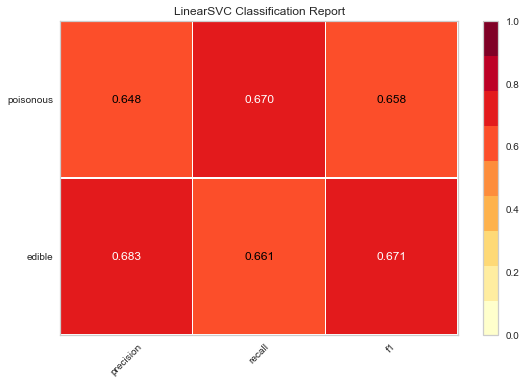

In [27]:
#Linear Support Vector machine (clustering)
visual_model_selection(X, y, LinearSVC())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


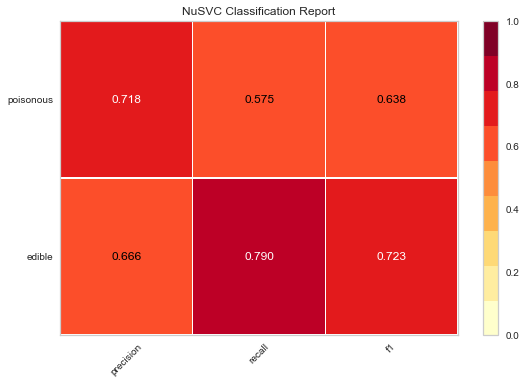

In [28]:
#NuSVC (clustering)
visual_model_selection(X, y, NuSVC())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


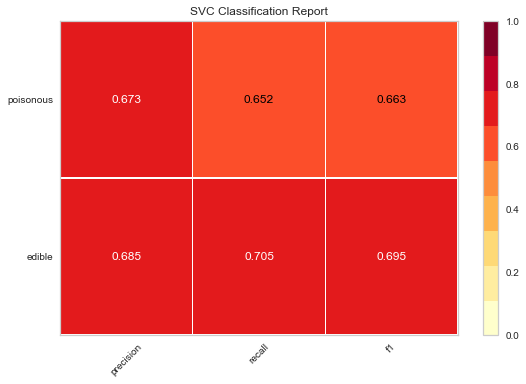

In [29]:
#SVC Classification
visual_model_selection(X, y, SVC())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


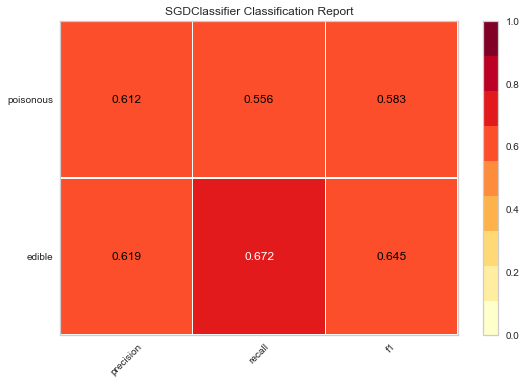

In [30]:
#Stochastic Gradient Descent Classifier
visual_model_selection(X, y, SGDClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


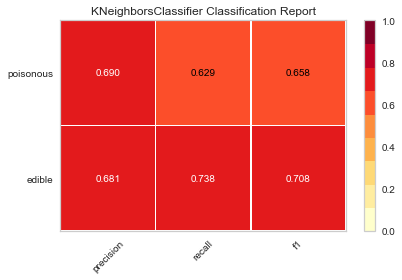

In [70]:
visual_model_selection(X, y, KNeighborsClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning:

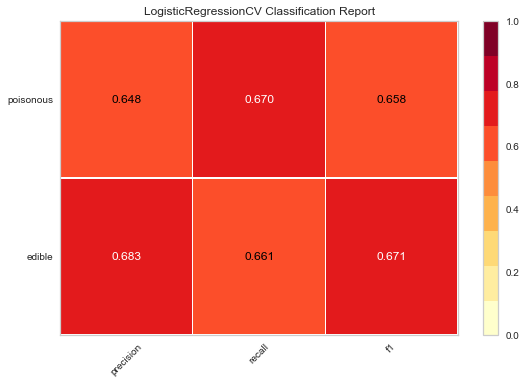

In [31]:
#Logistic Regression Cross Validation (Regression)
visual_model_selection(X, y, LogisticRegressionCV())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


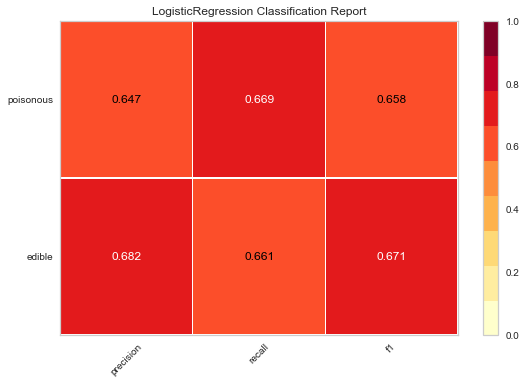

In [32]:
#Logistic Regression
visual_model_selection(X, y, LogisticRegression())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


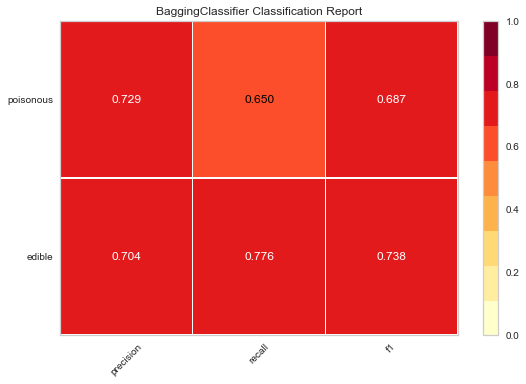

In [33]:
#Bagging Classifier
visual_model_selection(X, y, BaggingClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


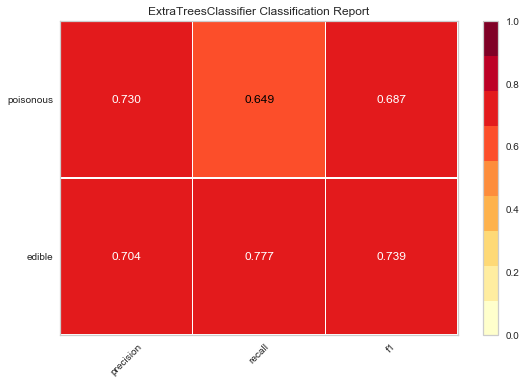

In [34]:
#ExtraTrees Classifier
visual_model_selection(X, y, ExtraTreesClassifier())

/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


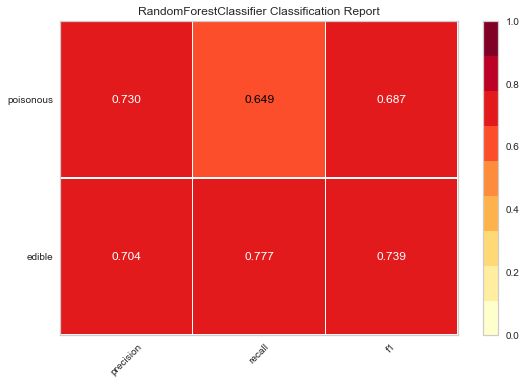

In [35]:
#RandomForestClassifier
visual_model_selection(X, y, RandomForestClassifier())

## Reflection

 1. Which model seems best now? Why?
 2. Which is most likely to save your life?
 3. How is the visual model evaluation experience different from numeric model evaluation?